# Optimization Study

- stop criteria: 

In [120]:
%config Completer.use_jedi = False

In [135]:
import math
import numpy as np
import pandas as pd
from cmaes import CMA
import seaborn as sns
from scipy.spatial.distance import pdist

## Objective Function

In [42]:
def ackley(x1, x2):
    # https://www.sfu.ca/~ssurjano/ackley.html
    return (
        -20 * math.exp(-0.2 * math.sqrt(0.5 * (x1 ** 2 + x2 ** 2)))
        - math.exp(0.5 * (math.cos(2 * math.pi * x1) + math.cos(2 * math.pi * x2)))
        + math.e + 20
    )

def errorfcn(alpha, Xbar, n, m):
    f1 = np.reshape(alpha[(2 * n):], (m, 2))
    f2 = np.reshape(alpha[0:2 * n], (2, n))
    f3 = Xbar[:, 0:n].T
    r = (Xbar - np.dot(f1, np.dot(f2, f3)).T) ** 2
    return np.nanmean(np.nanmean(r, axis=0))

In [191]:

bounds = np.array([[-32.768, 32.768], [-32.768, 32.768]])
lower_bounds, upper_bounds = bounds[:, 0], bounds[:, 1]

mean = lower_bounds + (np.random.rand(2) * (upper_bounds - lower_bounds))
sigma = 32.768 * 2 / 5  # 1/5 of the domain width
optimizer = CMA(mean=mean, sigma=sigma, bounds=bounds, seed=0)

for generation in range(200):
    solutions = []
    for _ in range(optimizer.population_size):
        x = optimizer.ask()
        value = ackley(x[0], x[1])
        solutions.append((x, value))
#         print(f"#{generation} {value} (x1={x[0]}, x2 = {x[1]})")
    optimizer.tell(solutions)

    if optimizer.should_stop():
        # popsize multiplied by 2 (or 3) before each restart.
        popsize = optimizer.population_size * 2
        mean = lower_bounds + (np.random.rand(2) * (upper_bounds - lower_bounds))
        optimizer = CMA(mean=mean, sigma=sigma, population_size=popsize)
        print(f"Restart CMA-ES with popsize={popsize}")


Restart CMA-ES with popsize=12
Restart CMA-ES with popsize=24


In [196]:
df = pd.read_csv('datasets/credit-g_metadata.csv').drop(columns = ['instances'])
performance_columns = [col for col in df.columns if col.startswith('algo')]
X = df.drop(columns = performance_columns)
Y = df[performance_columns]

In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   feature_kDN               1000 non-null   float64
 1   feature_Usefulness        1000 non-null   float64
 2   feature_N2                1000 non-null   float64
 3   feature_TD_P              1000 non-null   float64
 4   feature_CL                1000 non-null   float64
 5   feature_LSR               1000 non-null   float64
 6   feature_DS                1000 non-null   float64
 7   feature_N1                1000 non-null   float64
 8   feature_Harmfulness       1000 non-null   float64
 9   feature_DCP               1000 non-null   float64
 10  algo_bagging              1000 non-null   float64
 11  algo_gradient_boosting    1000 non-null   float64
 12  algo_logistic_regression  1000 non-null   float64
 13  algo_mlp                  1000 non-null   float64
 14  algo_rand

## IPOP-CMA-ES

In [199]:
# sns.scatterplot(x = X['feature_CL'], y = X['feature_F1'])
# sns.despine()

In [215]:
%%time
Xbar = np.hstack((X, Y))
n = X.shape[1]
m = Xbar.shape[1]

search_space = 32.768
bounds = list()
bounds.append([[-search_space, search_space] for i in range(2 * m + 2 * n)])
bounds = np.array(bounds).reshape((2 * m + 2 * n, 2))

lower_bounds, upper_bounds = bounds[:, 0], bounds[:, 1]
mean = lower_bounds + (np.random.rand(2 * m + 2 * n) * (upper_bounds - lower_bounds))
sigma = search_space * 2 / 5  # 1/5 of the domain width

optimizer = CMA(mean=mean, sigma=sigma, bounds=bounds, seed=0)

ntries = 1000
perf = np.zeros(ntries)
alpha = np.zeros((2 * m + 2 * n, ntries))
Hd = pdist(X)[np.newaxis].T

for generation in range(ntries):
    solutions = []
    
    for _ in range(optimizer.population_size):
        # Sample parameters to evaluate function
        alpha[:, generation] = optimizer.ask()
        
        # Calculate function value
        value = errorfcn(alpha = alpha[:, generation], Xbar = Xbar, n = n, m = m)
        solutions.append((alpha[:, generation], value))
#     print(f"#{generation} {value}")
    
    optimizer.tell(solutions)
#     print('shape alpha', alpha.shape, "alpha\n", alpha)
    aux = alpha[:, [generation]]
    A = np.reshape(aux[0:2 * n], (2, n))
    Z = np.dot(X, A.T)
    perf[generation] = np.corrcoef(Hd, pdist(Z)[np.newaxis].T, rowvar=False)[0][1]
    
    # Restart
    if optimizer.should_stop():
        print('Optimizer should stop')
        # popsize multiplied by 2 (or 3) before each restart.
        popsize = optimizer.population_size * 2
        
        mean = lower_bounds + (np.random.rand(2 * m + 2 * n) * (upper_bounds - lower_bounds))
        optimizer = CMA(mean=mean, sigma=sigma, population_size=popsize)
        print(f"Restart CMA-ES with popsize={popsize}")
    
idx = np.argmax(perf)
A = np.reshape(alpha[0:2 * n, idx], (2, n))
Z = np.dot(X, A.T)
B = np.reshape(alpha[(2 * n):, idx], (m, 2))
Xhat = np.dot(Z, B.T)
C = B[n:m + 1, :].T
B = B[0:n + 1, :]
error = np.sum((Xbar - Xhat) ** 2)

ValueError: Must tell popsize-length solutions.

In [201]:
error

17581829175.88035

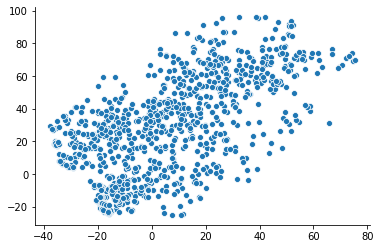

In [202]:
sns.scatterplot(x = Z[:, 0], y = Z[:, 1])
sns.despine()

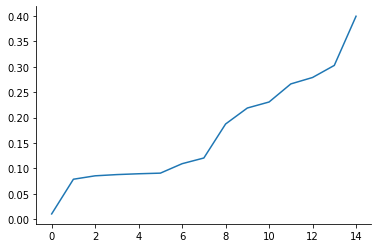

In [214]:
function_values = [s[1] for s in solutions] 

sns.lineplot(x = [i for i in range(len(function_values))],
             y = function_values)
sns.despine()